## Projeto-08-Data-science

Este notebook tem como objetivo fazer uma análise exploratória dos dados e gerar insights através dos resultados obtidos.

fonte dos dados: https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [1]:
#!pip install pandas_profiling --user --no-warn-script-location

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from sklearn.impute import KNNImputer
import math
import numpy as np

%matplotlib inline

### Info sobre as colunas

#### Estes dados foram coletados de pacientes do sexo feminino com idade a partir dos 21 anos na Índia

- *Pregnancies:* Vezes em que a pessoa ficou grávida
- *Glucose:* Concentração de glicose no sangue resultado do exame de tolerância a glucose de 2 horas
- *BloodPressure:* Pressão diastólica do sangue (mm Hg)
- *SkinThickness:* Espessura da dobra da pele no triceps (mm)
- *Insulin:* Insulina sérica de 2 horas (mu U/ml)
- *BMI:* Índice de massa corpórea (peso em kg / (peso em massa)^2)
- *DiabetesPedigreeFunction:* Exame que busca o histórico de diabetes mellitus na relação genética
- *Age:* Idade
- *Outcome:* 1 para diabetes positivo e 0 para diabetes negativo

# Análise exploratória dos dados

In [3]:
# importing the dataset
df = pd.read_csv("diabetes.csv")
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [4]:
# Using this library we see everything about the data, including missing values, zeros, etc.
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Verifying the information about the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# If has a null value
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
# some interesting informations about the dataframe
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

Após essa análise primária sobre os dados, podemos ver que não contém valores nulos porém contém **muitos zeros**, tirando a coluna "DiabetesPedigreeFunction", "Age" e "Outcome"(obviamente) todas as outras 6 colunas possuem valores zerados, seja por falta de dado ou por ser um dado real como no caso de "Pregnancies" que calcula a quantidade de vezes que a mulher esteve grávida...

Eu pensei em excluir os dados zerados, porém isso talvez não seja o melhor método para tratá-los. Então vou filtra-los pela média dos valores vizinhos. Tirando a coluna Pregnancies, farei a tratativa com as colunas restantes (**Glucose, BloodPressure, SkinThickness, Insulin e BMI**)

# Tratando os valores zerados

Para tratar os dados zerados vou utilizar a biblioteca KNN Imputer, que faz a média dos valores vizinhos e substituem os nulos. Como ele não aceita zero como valor nulo, preciso transforma-los em nulos para depois aplicar no imputer

Como ainda vou apenas explorar e analisar os dados, vou aplicar na função sem fazer o escalonamento, mas quando eu for aplicar em um algoritmo de machine learning vou refazer essa parte para não "enviesar" os dados

Como dito anteriormente, me interessa transformar apenas as colunas Glucose, BloodPressure, SkinThickness, Insulin e BMI

In [8]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [9]:
# Transforming the zeros into NaN for pass in KNN Imputer 
def transformar_zeros(df):
    for index, pregnancies, glucose, bloodpressure, skinthickness, insulin, bmi, diabetespedigreefunction, age, outcome  in df.itertuples():
        if glucose == 0:
            df.loc[df.index == index, 'Glucose'] = np.nan
            
        if bloodpressure == 0:
            df.loc[df.index == index, 'BloodPressure'] = np.nan
            
        if skinthickness == 0:
            df.loc[df.index == index, 'SkinThickness'] = np.nan
            
        if insulin == 0:
            df.loc[df.index == index, 'Insulin'] = np.nan
            
        if bmi == 0:
            df.loc[df.index == index, 'BMI'] = np.nan
            
        else:
            pass
        
    return df

In [10]:
# Before
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [11]:
# Before
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [12]:
# Data frame with new transformation
df_2 = transformar_zeros(df)

In [13]:
# Verifying the transformation
df_2.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  763.000000     733.000000     541.000000  394.000000   
mean      3.845052  121.686763      72.405184      29.153420  155.548223   
std       3.369578   30.535641      12.382158      10.476982  118.775855   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.000000      64.000000      22.000000   76.250000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  141.000000      80.000000      36.000000  190.000000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  757.000000                768.000000  768.000000  768.000000  
mean    32.457464                  0.471876   33.240885    0.348958  
std      6.924988                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.300000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [14]:
# New NaN values
df_2.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [15]:
# KNN Imputer
imputer = KNNImputer(n_neighbors=5)

imputed = imputer.fit_transform(df_2)

In [16]:
# New dataframe with the imputed data
df_3 = pd.DataFrame(imputed, columns=df_2.columns)
df_3.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.598177      72.371354      29.114583  153.180208   
std       3.369578   30.496543      12.206417       9.424100   98.385308   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.000000      64.000000      23.000000   87.900000   
50%       3.000000  117.000000      72.000000      29.000000  133.700000   
75%       6.000000  140.250000      80.000000      35.000000  190.150000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.427344                  0.471876   33.240885    0.348958  
std      6.886588                  0.331329   11.760232    0.476951  
min     18.200000                  0.078000   21.000000    0.000000  
25%     27.500000                  0.243750   24.000000    0.000000  
50%     32.090000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

# Respondendo as perguntas do desafio da trilha IA

## Quantas pessoas tem diabetes?

In [17]:
diabetes = df_3["Outcome"].value_counts()
print(diabetes)

0.0    500
1.0    268
Name: Outcome, dtype: int64


Como visto acima, a quantidade de pessoas que não tem diabetes (representados por 0) é superior às que tem (representados por 1), sendo 0 com um total de 500 pessoas e 1 com um total de 268 pacientes.

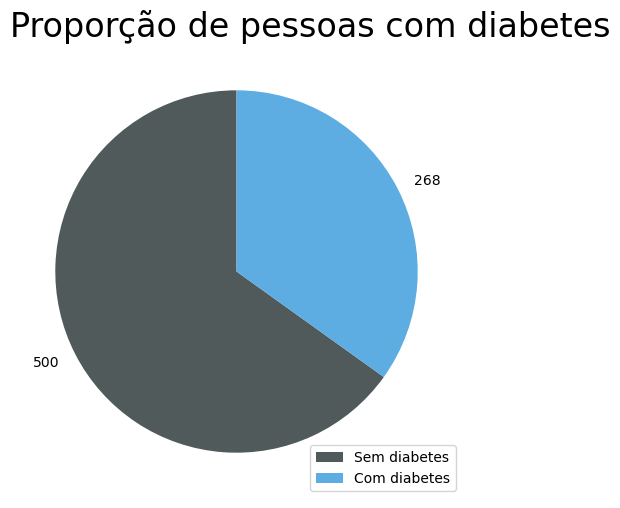

In [18]:
plt.figure(figsize=(6, 6), dpi=100)
plt.pie(diabetes, labels=diabetes, startangle=90, colors=['#515A5A', '#5DADE2'])
plt.title("Proporção de pessoas com diabetes", fontsize=24, loc='left')
plt.legend(["Sem diabetes", "Com diabetes"], loc='lower right')

plt.show()

Text(0.5, 1.0, 'Proporção de pessoas com diabetes')

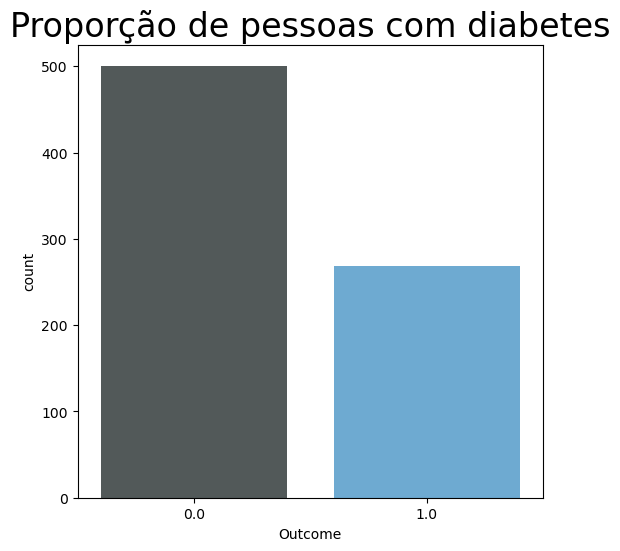

In [19]:
plt.figure(figsize=(6, 6), dpi=100)

sns.countplot(data = df_3, x='Outcome', palette=['#515A5A', '#5DADE2']
             ).set_title("Proporção de pessoas com diabetes", fontsize=24)

## Qual a média das pessoas com diabetes?

### Separando um dataframe apenas com pessoas que tem diabetes

In [20]:
# creating a dataset with only "Outcome == 1" (people who have diabetes)
df_dbt = df_3.query('Outcome == 1')
df_dbt.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.0  33.6   
2          8.0    183.0           64.0           25.8    164.6  23.3   
4          0.0    137.0           40.0           35.0    168.0  43.1   
6          3.0     78.0           50.0           32.0     88.0  31.0   
8          2.0    197.0           70.0           45.0    543.0  30.5   

   DiabetesPedigreeFunction   Age  Outcome  
0                     0.627  50.0      1.0  
2                     0.672  32.0      1.0  
4                     2.288  33.0      1.0  
6                     0.248  26.0      1.0  
8                     0.158  53.0      1.0

In [21]:
# The mean of people with diabetes
dbt_1 = df_3["Outcome"] == 1
dbt_1.mean()

0.3489583333333333

Os pacientes com diabetes representam 34,89% dos dados.

In [22]:
dbt_0 = df["Outcome"] == 0
dbt_0.mean()

0.6510416666666666

Já o restante das pessoas dos dados e que representam o grupo de não-diabéticos são o complementar de 65,1%

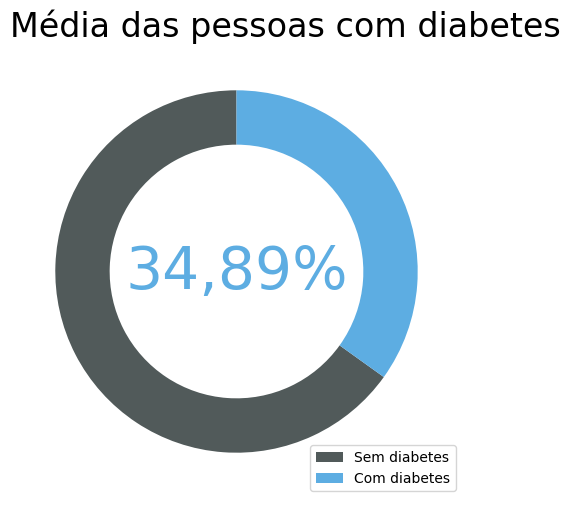

In [23]:
wedgeprops = {'width':0.3, 'linewidth':3}

plt.figure(figsize=(6, 6), dpi=100)
plt.pie(diabetes, wedgeprops=wedgeprops, startangle=90, colors=['#515A5A', '#5DADE2'])
plt.title('Média das pessoas com diabetes', fontsize=24, loc='left')
plt.text(0, 0, "34,89%", color= '#5DADE2', ha='center', va='center', fontsize=42)
plt.legend(["Sem diabetes", "Com diabetes"], loc='lower right')

plt.show()

## Qual a pressão sanguínea média das pessoas com diabetes?

"BloodPressure" seria a coluna que representa a pressão sanguínea diastólica dos pacientes, ou seja, a "pressão mínima". Ocorre no início do ciclo cardíaco e se refere à capacidade de adaptação ao volume de sangue que o coração ejetou.

O valores considerados normais para mulheres em uma faixa de 21 a 60 anos seria entre 79 mmHg a 84 mmHg.

In [24]:
# Unique values for each data
df_dbt.BloodPressure.unique()

array([ 72. ,  64. ,  40. ,  50. ,  70. ,  96. ,  74. ,  60. ,  71.6,
        84. ,  90. ,  80. ,  94. ,  76. ,  68. , 110. ,  66. ,  88. ,
        70.4, 108. ,  85. ,  62. ,  54. ,  92. ,  30. ,  56. ,  86. ,
        78. ,  82. ,  98. ,  84.8, 104. ,  65. ,  52. ,  74.6,  69.2,
        48. ,  58. ,  83.2,  82.4, 102. ,  75. , 100. ,  67.8,  81.4,
        72.8,  76.8, 106. , 114. ,  82.8])

In [25]:
# The mean of Blood Pressure 
mean_bp = df_dbt["BloodPressure"].mean()
mean_bp = math.floor(mean_bp)

print(f'A média da pressão sanguínea dos pacientes com diabetes é: {mean_bp} mmHg')

A média da pressão sanguínea dos pacientes com diabetes é: 75 mmHg


Text(1.1, 1.2, 'Média: 75 mmHg')

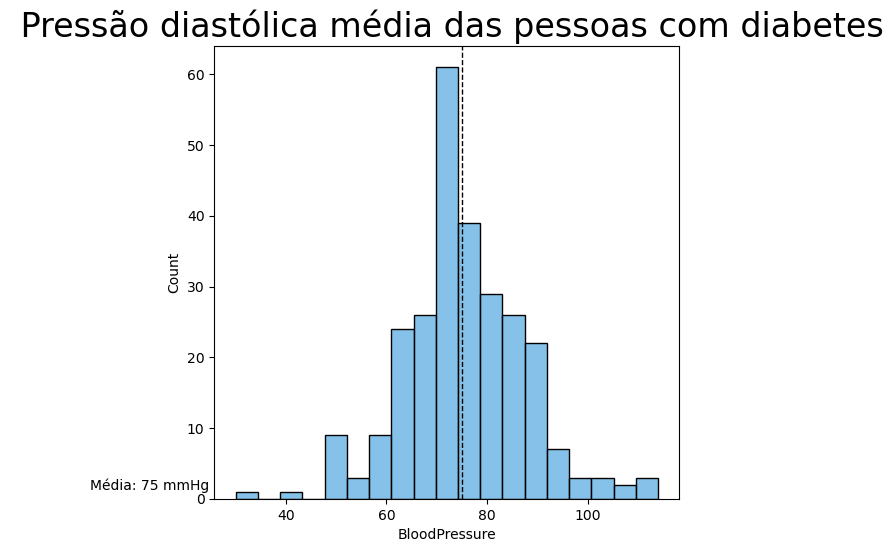

In [26]:
# Ploting

plt.figure(figsize=(6, 6), dpi=100)

sns.histplot(df_dbt['BloodPressure'], color='#5DADE2'
            ).set_title(" Pressão diastólica média das pessoas com diabetes", fontsize=24)

plt.axvline(mean_bp, color='k', linestyle='dashed', linewidth=1)
plt.text(1.1, 1.2, s=(f"Média: {mean_bp} mmHg"))

## Qual a idade média das pessoas com diabetes?

Lembrando que os dados foram coletados de mulheres a apartir de 21 anos

In [27]:
# Unique values for each data
df_dbt.Age.unique()

array([50., 32., 33., 26., 53., 54., 34., 59., 51., 31., 41., 29., 43.,
       28., 46., 27., 56., 25., 58., 39., 42., 38., 37., 60., 24., 61.,
       23., 40., 62., 30., 36., 47., 57., 52., 21., 66., 22., 49., 44.,
       35., 67., 45., 55., 70., 48.])

In [28]:
# Mean age
mean_age = df_dbt["Age"].mean()
mean_age = math.floor(mean_age)

print(f'A idade média das pessoas com diabetes é {mean_age} anos')

A idade média das pessoas com diabetes é 37 anos


Text(1.1, 1.2, 'Média: 37 Anos')

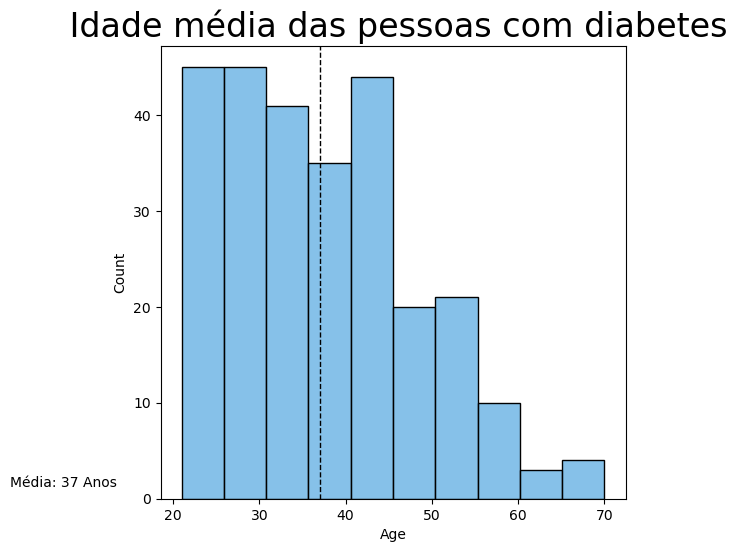

In [29]:
# Ploting
plt.figure(figsize=(6, 6), dpi=100)

sns.histplot(df_dbt['Age'], color='#5DADE2'
            ).set_title(" Idade média das pessoas com diabetes", fontsize=24)

plt.axvline(mean_age, color='k', linestyle='dashed', linewidth=1)
plt.text(1.1, 1.2, s=(f"Média: {mean_age} Anos"))

## Comparação da quantidade de açúcar no sangue entre pessoas que tem e quem não tem diabetes

### Primeiro com pessoas sem diabetes

In [30]:
# Data frame with people who don't have diabete
no_dbt = df_3.query('Outcome == 0')

In [31]:
# Mean
print(f" Média de glicose no sangue das pessoas sem diabetes {round(no_dbt.Glucose.mean())}")

 Média de glicose no sangue das pessoas sem diabetes 111


In [32]:
# Max
print(f" Valor máximo de glicose no sangue das pessoas sem diabetes {no_dbt.Glucose.max()}")

 Valor máximo de glicose no sangue das pessoas sem diabetes 197.0


In [33]:
# Min
print(f"Valor mínimo de glicose no sangue das pessoas sem diabetes {no_dbt.Glucose.min()}")

Valor mínimo de glicose no sangue das pessoas sem diabetes 44.0


Text(1.1, 1.2, 'Média: 111')

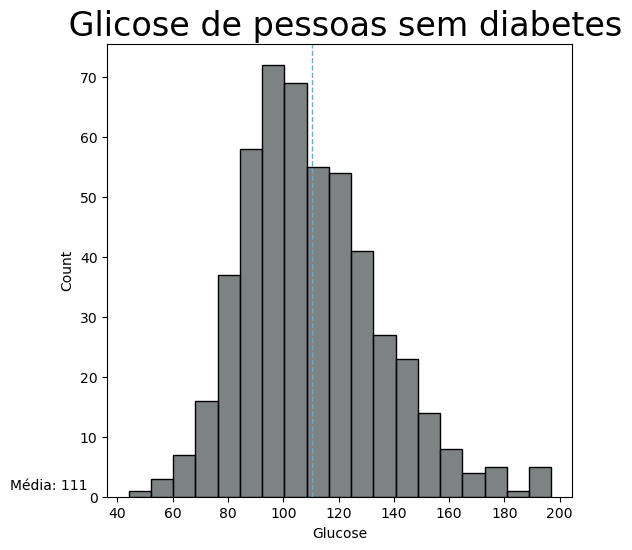

In [34]:
# Ploting
plt.figure(figsize=(6, 6), dpi=100)

sns.histplot(no_dbt['Glucose'], color='#515A5A'
            ).set_title(" Glicose de pessoas sem diabetes", fontsize=24)

plt.axvline(no_dbt.Glucose.mean(), color='#5DADE2', linestyle='dashed', linewidth=1)
plt.text(1.1, 1.2, s=(f"Média: {round(no_dbt.Glucose.mean())}"))

### Agora com pessoas com diabetes

In [35]:
# Mean
print(f" Média de glicose no sangue das pessoas com diabetes {round(df_dbt.Glucose.mean())}")

 Média de glicose no sangue das pessoas com diabetes 142


In [36]:
# Max
print(f" Valor máximo de glicose no sangue das pessoas comdiabetes {df_dbt.Glucose.max()}")

 Valor máximo de glicose no sangue das pessoas comdiabetes 199.0


In [37]:
# Min
print(f" VAlor mínimo de glicose no sangue das pessoas com diabetes {df_dbt.Glucose.min()}")

 VAlor mínimo de glicose no sangue das pessoas com diabetes 78.0


Text(1.1, 1.2, 'Média: 142')

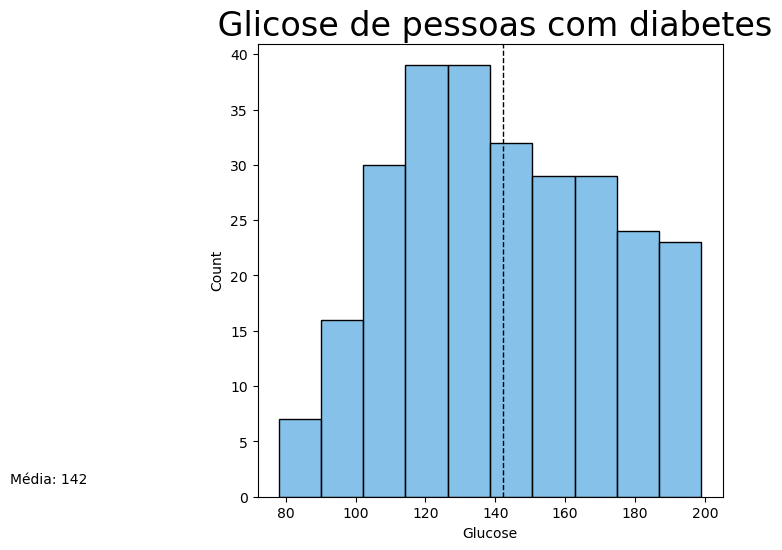

In [38]:
# Ploting
plt.figure(figsize=(6, 6), dpi=100)

sns.histplot(df_dbt['Glucose'], color='#5DADE2'
            ).set_title(" Glicose de pessoas com diabetes", fontsize=24)

plt.axvline(df_dbt.Glucose.mean(), color='k', linestyle='dashed', linewidth=1)
plt.text(1.1, 1.2, s=(f"Média: {round(df_dbt.Glucose.mean())}"))

## Qual a correlação da gravidez com o diabetes?

In [39]:
df_3.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0    169.0  33.6   
1          1.0     85.0           66.0           29.0     58.6  26.6   
2          8.0    183.0           64.0           25.8    164.6  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          0.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction   Age  Outcome  
0                     0.627  50.0      1.0  
1                     0.351  31.0      0.0  
2                     0.672  32.0      1.0  
3                     0.167  21.0      0.0  
4                     2.288  33.0      1.0

In [40]:
# Correlation
df_3[["Pregnancies", "Outcome"]].corr()

Pregnancies   Outcome
Pregnancies     1.000000  0.221898
Outcome         0.221898  1.000000

## Correlação das colunas com o diabetes

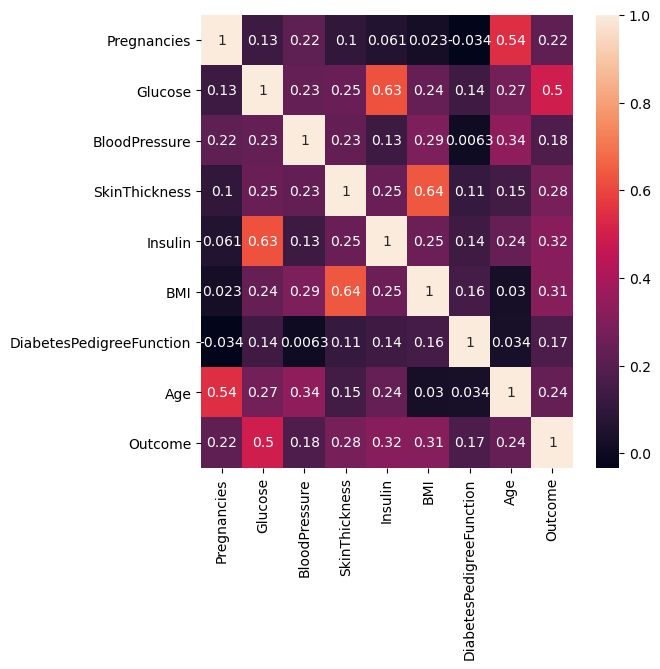

In [41]:
# Heatmap
plt.figure(figsize=(6, 6), dpi=100)

corr_df = df_3.corr(method='pearson')

sns.heatmap(corr_df, annot=True)
plt.show()

## Conclusão

Com base nos dados analisados concluímos que:

1) Apenas 35% das pessoas do conjunto de dados possuem diabetes

2) A pressão diastólica das pessoas com diabetes é em média 75 mmHg

3) A idade média dos pacientes diabéticos é de 37 anos

4) A concentração de glicose no sangue de uma pessoa com diabetes é, em média 142 já uma pessoa que não tem é em média 111

5) A gravidez não tem muita correlação com o diabetes, já a Glicose, IMC, Insulina e a espessura da dobra da pele possuem uma notável correlação

In [42]:
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
#df.head()